# CSE251B Project Milestone Starter File

## Step 1: Import Dependencies:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

## Step 2: Load the Dataset

#### You need to describe in your own words what the dataset is about, and use mathematical language and formulate your prediction task on the submitted PDF file for Question 1 Problem A.

#### Here we are loading the dataset from the local directory. And answer Question 1 Problem B

In [2]:
train_npz = np.load('./train.npz')
train_data = train_npz['data']
test_npz  = np.load('./test_input.npz')
test_data  = test_npz['data']

In [3]:
print(train_data.shape, test_data.shape)

# Split once for later use
X_train = train_data[..., :50, :]
Y_train = train_data[:, 0, 50:, :2]

(10000, 50, 110, 6) (2100, 50, 50, 6)


In [4]:
def plot_heatmap(data, title=None, bins=5):
    plt.figure(figsize=(6, 6))

    x_max = data[..., 0].max()
    x_min = data[..., 0].min()
    y_max = data[..., 1].max()
    y_min = data[..., 1].min()

    plt.hist2d(data[:, 0], data[:, 1], bins=bins, cmap='hot')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(title)
    plt.colorbar(label='Density')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

In [5]:
xy_in = train_data[:, :, :50, :2].reshape(-1, 2)
# only find the x, y != 0
xy_in_not_0 = xy_in[(xy_in[:, 0] != 0) & (xy_in[:, 1] != 0)]

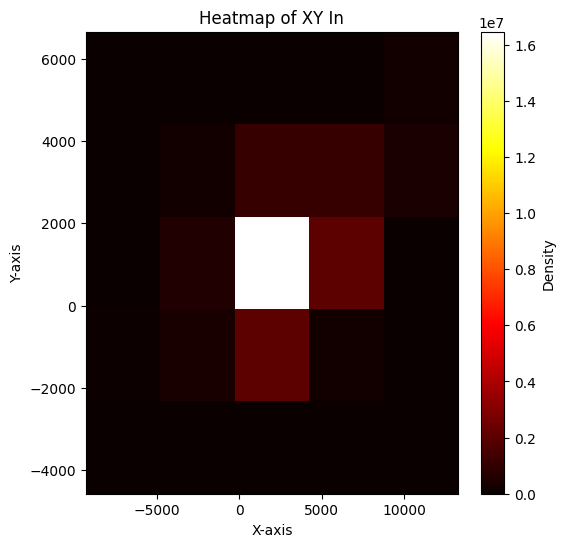

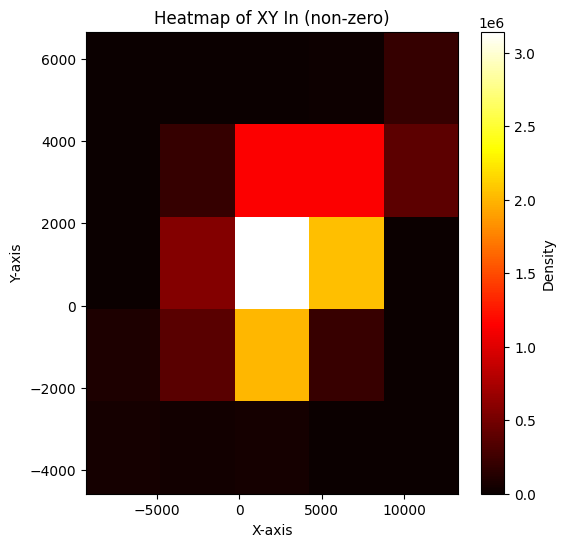

In [6]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=5)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=5)

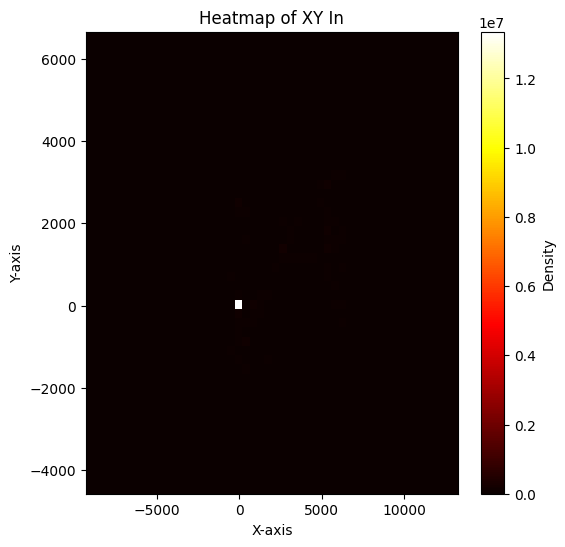

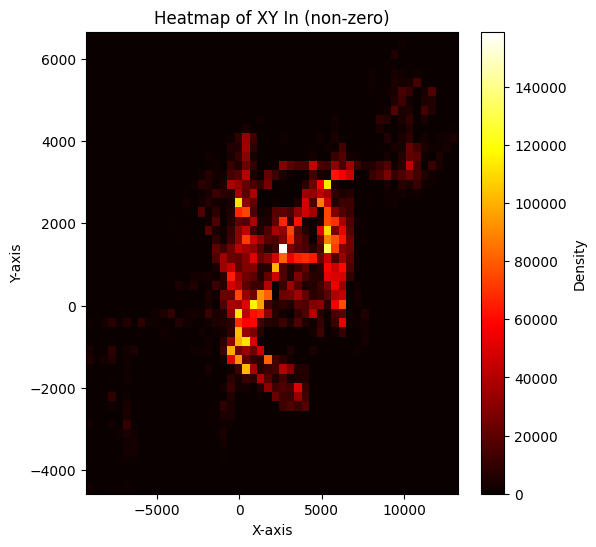

In [7]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=50)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=50)

#### Try to play around with dataset for training and testing, make exploratory analysis on the dataset for bonus points(up to 2)

## Step 3: Setting up the Training and Testing

### Example Code:

In [8]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

#### Answer Question related to Your Computational Platform and GPU for Question 2 Problem A

In [ ]:
torch.manual_seed(251)
np.random.seed(42)

scale = 10.0

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x)
)
val_dataloader = DataLoader(
    val_dataset, batch_size=64, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x)
)

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using CUDA GPU


#### Your Model for Question 2 Problem B (Include your model architecture pictures and also can use some mathmatical equations to explain your model in your report)

In [10]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim=50 * 50 * 2, output_dim=60 * 2):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, data):
        x = data.x[..., :2] # (batch*50, 50, 2)
        x = x.reshape(-1, 50 * 50 * 2) # (batch, 5000)
        x = self.linear(x)
        return x.view(-1, 60, 2)

In [11]:
class MLP(nn.Module):
    def __init__(self, input_features, output_features):
        super(MLP, self).__init__()
        
        # Define the layers
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(input_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(256, output_features)
        )
    
    def forward(self, data):
        x = data.x
        x = x[:, :, :, :2] # (batch, 50, 50, 2)
        x = x.reshape(-1, 50 * 50 * 6)
        x = self.mlp(x)
        return x.view(-1, 60, 2)

#### This Model will be covered during Week 6 Lecture (If you don't understand it for now, don't worry, we will cover it in the lecture, or you can ask in the office hours)

In [12]:
class LSTM(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, output_dim=60 * 2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x = data.x
        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :] # Only Consider ego agent index 0

        lstm_out, _ = self.lstm(x)
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        out = self.fc(lstm_out[:, -1, :])
        return out.view(-1, 60, 2)

#### Trying Transformer Model

In [13]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim=6, model_dim=128, num_heads=4, num_layers=2, output_dim=60*2, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.input_proj = nn.Linear(input_dim, model_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(model_dim, output_dim)

    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :]  # Only consider ego agent index 0, shape: (batch, 50, 6)
        x = self.input_proj(x)  # (batch, 50, model_dim)
        x = self.transformer_encoder(x)  # (batch, 50, model_dim)
        out = self.fc(x[:, -1, :])  # Use last time step's output
        return out.view(-1, 60, 2)

In [14]:
class AdvancedTransformerModel(nn.Module):
    def __init__(
        self,
        input_dim=6,
        model_dim=256,
        num_heads=8,
        num_layers=6,
        seq_len=50,
        future_len=60,
        dropout=0.15
    ):
        super().__init__()
        self.seq_len = seq_len
        self.future_len = future_len
        self.input_proj = nn.Linear(input_dim, model_dim)
        
        # Learnable positional encoding
        self.pos_encoding = nn.Parameter(torch.randn(1, seq_len, model_dim))
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=num_heads,
            dim_feedforward=model_dim*4,
            dropout=dropout,
            batch_first=True,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Decoder for future trajectory
        self.decoder = nn.Sequential(
            nn.LayerNorm(model_dim),
            nn.Linear(model_dim, model_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(model_dim, future_len * 2)
        )

    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6)  # (batch, agents, seq, features)
        x = x[:, 0, :, :]  # Only ego agent: (batch, seq, features)
        x = self.input_proj(x)  # (batch, seq, model_dim)
        x = x + self.pos_encoding[:, :self.seq_len, :]  # Add positional encoding
        x = self.encoder(x)  # (batch, seq, model_dim)
        x = x[:, -1, :]  # Use last time step's output (batch, model_dim)
        out = self.decoder(x)  # (batch, future_len*2)
        return out.view(-1, self.future_len, 2)

In [15]:
class BeefedTransformerModel(nn.Module):
    def __init__(
        self,
        input_dim=6,
        model_dim=256,
        num_heads=8,
        num_layers=6,
        seq_len=50,
        future_len=60,
        dropout=0.15
    ):
        super().__init__()
        self.seq_len = seq_len
        self.future_len = future_len

        # Temporal convolution for local feature extraction
        self.temporal_conv = nn.Conv1d(input_dim, input_dim, kernel_size=3, padding=1, groups=input_dim)
        self.input_proj = nn.Linear(input_dim, model_dim)

        # Learnable positional encoding
        self.pos_encoding = nn.Parameter(torch.randn(1, seq_len, model_dim))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=num_heads,
            dim_feedforward=model_dim*6,
            dropout=dropout,
            batch_first=True,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Deeper MLP decoder with residual connection
        self.decoder = nn.Sequential(
            nn.LayerNorm(model_dim),
            nn.Linear(model_dim, model_dim*2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(model_dim*2, model_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(model_dim, future_len * 2)
        )

    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6)
        x = x[:, 0, :, :]  # Only ego agent: (batch, seq, features)
        # Temporal convolution
        x = x.transpose(1, 2)  # (batch, features, seq)
        x = self.temporal_conv(x)
        x = x.transpose(1, 2)  # (batch, seq, features)
        x = self.input_proj(x)
        x = x + self.pos_encoding[:, :self.seq_len, :]
        x = self.encoder(x)
        x = x[:, -1, :]  # Last time step
        out = self.decoder(x)
        return out.view(-1, self.future_len, 2)

In [16]:
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class GNNModel(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=256, num_heads = 4, num_layers=4, output_dim=60*2, dropout=0.1):
        super(GNNModel, self).__init__()
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        
        # GNN layers
        self.convs = nn.ModuleList()
        for i in range(num_layers):
            self.convs.append(GATConv(hidden_dim, hidden_dim//4, heads=num_heads))
        
        self.dropout = dropout
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :]  # Only consider ego agent, shape: (batch, 50, 6)
        
        # Project input features
        node_features = self.input_proj(x)  # (batch, 50, hidden_dim)
        
        batch_size = node_features.size(0)
        seq_len = node_features.size(1)
        
        # Process each batch separately
        outputs = []
        for b in range(batch_size):
            # Get features for this sequence
            seq_features = node_features[b]  # (50, hidden_dim)
            
            # Create a fully connected graph where each node (timestep) is connected to all others
            edge_index = []
            for i in range(seq_len):
                for j in range(seq_len):
                    if i != j:  # Connect every node to every other node
                        edge_index.append([i, j])
            
            edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous().to(seq_features.device)
            
            # Apply GNN layers
            h = seq_features
            for conv in self.convs:
                h = conv(h, edge_index)
                h = F.relu(h)
                h = F.dropout(h, p=self.dropout, training=self.training)
            
            # Get the final timestep's representation
            outputs.append(h[-1].unsqueeze(0))  # (1, hidden_dim)
        
        # Combine outputs from all batches
        h = torch.cat(outputs, dim=0)  # (batch, hidden_dim)
        
        # Final prediction
        out = self.fc(h)  # (batch, output_dim)
        return out.view(-1, 60, 2)

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class MultiAgentGNN(nn.Module):
    def __init__(
        self, 
        input_dim=6, 
        hidden_dim=256, 
        num_heads=8, 
        num_layers=4,
        future_len=60,
        max_agents=3,  # Only consider top k nearest agents
        dropout=0.1
    ):
        super(MultiAgentGNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.future_len = future_len
        self.max_agents = max_agents
        
        # Feature extraction
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU()
        )
        
        # Temporal positional encoding
        self.pos_encoding = nn.Parameter(torch.randn(1, 50, hidden_dim))
        
        # Agent type embedding (ego=0, others=1)
        self.agent_type_embedding = nn.Parameter(torch.randn(2, hidden_dim))
        
        # Create temporal edges once (same for all samples)
        seq_len = 50
        self.temporal_edges = []
        for i in range(seq_len):
            # Forward connections (i -> i+k)
            for k in range(1, min(6, seq_len - i)):  # Connect to 5 future steps
                self.temporal_edges.append([i, i+k])
            # Backward connections (i -> i-k)
            for k in range(1, min(6, i + 1)):  # Connect to 5 past steps
                self.temporal_edges.append([i, i-k])
        # Always connect to the last timestep
        for i in range(seq_len - 1):
            self.temporal_edges.append([i, seq_len - 1])
        self.register_buffer('temporal_edge_index', 
                            torch.tensor(self.temporal_edges, dtype=torch.long).t().contiguous())
        
        # Temporal GNN layers
        self.temporal_convs = nn.ModuleList()
        self.temporal_norms = nn.ModuleList()
        
        for i in range(num_layers):
            self.temporal_convs.append(GATConv(
                hidden_dim, 
                hidden_dim // num_heads, 
                heads=num_heads, 
                dropout=dropout
            ))
            self.temporal_norms.append(nn.LayerNorm(hidden_dim))
        
        # Social attention for agent interaction
        self.social_attention = nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=num_heads//2,
            dropout=dropout,
            batch_first=True
        )
        self.social_norm = nn.LayerNorm(hidden_dim)
            
        # Trajectory prediction layers
        self.trajectory_predictor = nn.Sequential(
            nn.Linear(hidden_dim*2, hidden_dim*2),  # Concat ego and social features
            nn.LayerNorm(hidden_dim*2),
            nn.Dropout(dropout),
            nn.GELU(),
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(dropout),
            nn.GELU(),
            nn.Linear(hidden_dim, future_len * 2)
        )
        
        # Initialize weights
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_normal_(module.weight, gain=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
    
    def forward(self, data):
        x = data.x  # (batch*agents, seq_len, features)
        batch_size = data.num_graphs
        
        # Reshape to get explicit agent dimension
        x = x.reshape(batch_size, 50, 50, -1)  # (batch, agents, seq_len, features)
        
        # Process in parallel for all batches
        all_outputs = []
        
        for b in range(batch_size):
            scene = x[b]  # (agents, seq_len, features)
            
            # Find non-zero agents (valid agents with actual data)
            # Sum across spatial and feature dimensions
            agent_mask = torch.sum(torch.abs(scene[:, -1, :2]), dim=-1) > 1e-6
            valid_agents = torch.where(agent_mask)[0]
            
            # Always include ego agent (index 0)
            if 0 not in valid_agents:
                valid_agents = torch.cat([torch.tensor([0], device=x.device), valid_agents])
            
            # Select top-k nearest agents to ego (based on last timestamp)
            if len(valid_agents) > self.max_agents:
                ego_pos = scene[0, -1, :2]  # Ego agent's last position
                other_agents = valid_agents[valid_agents != 0]
                other_pos = scene[other_agents, -1, :2]  # Other agents' last positions
                
                # Calculate distances to ego
                distances = torch.norm(other_pos - ego_pos, dim=-1)
                
                # Get indices of k-1 nearest agents
                _, nearest_indices = torch.topk(distances, min(len(distances), self.max_agents-1), largest=False)
                selected_agents = torch.cat([torch.tensor([0], device=x.device), 
                                          other_agents[nearest_indices]])
            else:
                selected_agents = valid_agents
            
            # Extract features for selected agents
            agents_features = []
            agent_types = []
            
            for idx, agent_idx in enumerate(selected_agents):
                # Agent type: 0 for ego, 1 for others
                agent_type = 0 if agent_idx == 0 else 1
                agent_types.append(agent_type)
                
                # Extract and process features
                agent_feat = scene[agent_idx]  # (seq_len, features)
                agent_feat = self.feature_extractor(agent_feat)  # (seq_len, hidden_dim)
                
                # Add positional encoding and agent type embedding
                agent_feat = agent_feat + self.pos_encoding[0] + self.agent_type_embedding[agent_type]
                
                # Apply temporal GNN
                for i, (conv, norm) in enumerate(zip(self.temporal_convs, self.temporal_norms)):
                    h_new = conv(agent_feat, self.temporal_edge_index)
                    h_new = F.gelu(h_new)
                    if i < len(self.temporal_convs) - 1:
                        h_new = F.dropout(h_new, p=0.1, training=self.training)
                    agent_feat = agent_feat + h_new  # Residual
                    agent_feat = norm(agent_feat)  # Normalization
                
                # Use the last timestep's features
                agents_features.append(agent_feat[-1])  # (hidden_dim)
            
            # Stack all agent features
            if len(agents_features) > 0:
                agents_features = torch.stack(agents_features, dim=0)  # (num_agents, hidden_dim)
                
                # Apply social attention - ego agent attends to others
                ego_feat = agents_features[0:1]  # (1, hidden_dim)
                
                if len(agents_features) > 1:
                    # Social attention between ego and other agents
                    social_context, _ = self.social_attention(
                        ego_feat,  # Query: ego agent
                        agents_features,  # Keys: all agents
                        agents_features,  # Values: all agents
                    )
                    social_context = self.social_norm(social_context + ego_feat)  # Residual
                else:
                    social_context = ego_feat
                
                # Combine ego features with social context
                combined_feat = torch.cat([ego_feat, social_context], dim=-1)  # (1, hidden_dim*2)
                
                # Predict future trajectory
                future_traj = self.trajectory_predictor(combined_feat)  # (1, future_len*2)
                future_traj = future_traj.view(1, self.future_len, 2)  # (1, future_len, 2)
                
                all_outputs.append(future_traj)
            else:
                # Fallback if no valid agents (shouldn't happen)
                zero_traj = torch.zeros((1, self.future_len, 2), device=x.device)
                all_outputs.append(zero_traj)
        
        # Combine all batch outputs
        if all_outputs:
            output = torch.cat(all_outputs, dim=0)  # (batch, future_len, 2)
            return output
        else:
            return torch.zeros((batch_size, self.future_len, 2), device=x.device)

In [18]:
class GNNTransformerLite(nn.Module):
    def __init__(
        self,
        input_dim=6,
        gnn_hidden=64,
        gnn_heads=2,
        gnn_layers=1,
        trans_dim=64,
        trans_heads=2,
        trans_layers=1,
        seq_len=50,
        future_len=60,
        dropout=0.15
    ):
        super().__init__()
        self.seq_len = seq_len
        self.future_len = future_len

        # GNN for agent interaction at last timestep
        self.gnn_input = nn.Linear(input_dim, gnn_hidden)
        self.gnn = GATConv(gnn_hidden, gnn_hidden, heads=gnn_heads, dropout=dropout)
        self.gnn_norm = nn.LayerNorm(gnn_hidden * gnn_heads)

        # Transformer for ego temporal encoding
        self.trans_input = nn.Linear(input_dim, trans_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=trans_dim, nhead=trans_heads, dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=trans_layers)
        self.trans_norm = nn.LayerNorm(trans_dim)

        # Final fusion and prediction
        self.fc = nn.Sequential(
            nn.Linear(gnn_hidden * gnn_heads + trans_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, future_len * 2)
        )

    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6)  # (batch, agents, seq, features)
        batch_size = x.shape[0]

        # --- GNN: agent interaction at last timestep ---
        last_timestep = x[:, :, -1, :]  # (batch, agents, features)
        gnn_in = self.gnn_input(last_timestep)  # (batch, agents, gnn_hidden)
        # Fully connected graph for agents
        edge_index = torch.combinations(torch.arange(gnn_in.shape[1]), r=2).t().to(x.device)
        gnn_out = []
        for b in range(batch_size):
            h = self.gnn(gnn_in[b], edge_index)
            h = F.relu(h)
            h = self.gnn_norm(h)
            gnn_out.append(h[0])  # Use ego agent (index 0)
        gnn_out = torch.stack(gnn_out, dim=0)  # (batch, gnn_hidden * gnn_heads)

        # --- Transformer: ego agent temporal encoding ---
        ego_traj = x[:, 0, :, :]  # (batch, seq, features)
        trans_in = self.trans_input(ego_traj)
        trans_out = self.transformer(trans_in)
        trans_out = self.trans_norm(trans_out[:, -1, :])  # Last time step

        # --- Concatenate and predict ---
        fused = torch.cat([gnn_out, trans_out], dim=-1)
        out = self.fc(fused)
        return out.view(-1, self.future_len, 2)

In [19]:
class GNNTransformerDeep(nn.Module):
    def __init__(
        self,
        input_dim=6,
        gnn_hidden=128,
        gnn_heads=4,
        gnn_layers=2,
        trans_dim=128,
        trans_heads=4,
        trans_layers=2,
        seq_len=50,
        future_len=60,
        dropout=0.1
    ):
        super().__init__()
        self.seq_len = seq_len
        self.future_len = future_len

        # Multi-layer GNN for agent interaction at each timestep
        self.gnn_input = nn.Linear(input_dim, gnn_hidden)
        self.gnn_layers = nn.ModuleList()
        for i in range(gnn_layers):
            in_dim = gnn_hidden if i == 0 else gnn_hidden * gnn_heads
            self.gnn_layers.append(
                GATConv(in_dim, gnn_hidden, heads=gnn_heads, dropout=dropout)
            )
        self.gnn_norm = nn.LayerNorm(gnn_hidden * gnn_heads)

        # Transformer for ego temporal encoding
        self.trans_input = nn.Linear(input_dim, trans_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=trans_dim, nhead=trans_heads, dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=trans_layers)
        self.trans_norm = nn.LayerNorm(trans_dim)

        # Final fusion and prediction
        self.fc = nn.Sequential(
            nn.Linear(gnn_hidden * gnn_heads + trans_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, future_len * 2)
        )

    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6)  # (batch, agents, seq, features)
        batch_size = x.shape[0]
        num_agents = x.shape[1]

        # --- GNN: agent interaction at each timestep ---
        gnn_out = []
        edge_index = torch.combinations(torch.arange(num_agents), r=2).t().to(x.device)
        for b in range(batch_size):
            timestep_features = []
            for t in range(self.seq_len):
                agents_t = x[b, :, t, :]  # (agents, features)
                h = self.gnn_input(agents_t)
                for i, gnn in enumerate(self.gnn_layers):
                    h = gnn(h, edge_index)
                    h = F.relu(h)
                timestep_features.append(h[0])  # Use ego agent (index 0)
            gnn_out.append(torch.stack(timestep_features, dim=0))  # (seq, gnn_hidden * gnn_heads)
        gnn_out = torch.stack(gnn_out, dim=0)  # (batch, seq, gnn_hidden * gnn_heads)
        gnn_out_last = self.gnn_norm(gnn_out[:, -1, :])  # (batch, gnn_hidden * gnn_heads)

        # --- Transformer: ego agent temporal encoding ---
        ego_traj = x[:, 0, :, :]  # (batch, seq, features)
        trans_in = self.trans_input(ego_traj)
        trans_out = self.transformer(trans_in)
        trans_out = self.trans_norm(trans_out[:, -1, :])  # Last time step

        # --- Concatenate and predict ---
        fused = torch.cat([gnn_out_last, trans_out], dim=-1)
        out = self.fc(fused)
        return out.view(-1, self.future_len, 2)

#### Your Optimizer and Hyperparameters for Question 2 Problem A (Try to use different optimizers and hyperparameters for your model and see how it affects the performance of your model)

In [20]:
# model = LinearRegressionModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
# model = LSTM().to(device)
# model = TransformerModel().to(device)
# model = AdvancedTransformerModel().to(device)
# model = AdvancedTransformerModel(
#     input_dim=6,
#     model_dim=512,      # 2x wider
#     num_heads=16,       # 2x more heads
#     num_layers=12,      # 2x deeper
#     seq_len=50,
#     future_len=60,
#     dropout=0.10        # Slightly higher dropout for regularization
# ).to(device)
# model = BeefedTransformerModel(
#     input_dim=6,
#     model_dim=1152,
#     num_heads=36,
#     num_layers=20,
#     seq_len=50,
#     future_len=60,
#     dropout=0.15
# ).to(device)
# model_dim=128, num_heads=4, num_layers=2


#### Using the Simple Linear Regression Model for Question 2B and Visualize the validation loss(MAE) (Hint: You should adapt the code for training loss and try to draw graphs as specified in the project description)

In [ ]:
from sklearn.model_selection import KFold

k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
all_indices = np.arange(len(train_data))
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(all_indices)):
    print(f"\n--- Fold {fold+1}/{k_folds} ---")
    if fold == 1:
        break

    # Create datasets for this fold
    train_dataset = TrajectoryDatasetTrain(train_data[train_idx], scale=scale, augment=True)
    val_dataset = TrajectoryDatasetTrain(train_data[val_idx], scale=scale, augment=False)
    train_dataloader = DataLoader(
        train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x)
    )
    val_dataloader = DataLoader(
        val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x)
    )
    
    model = GNNTransformerLite(
        gnn_hidden=256,
        gnn_heads=8,
        gnn_layers=4,
        trans_dim=256,
        trans_heads=8,
        trans_layers=4,
        dropout=0
    ).to(device)

    # Modified training setup
    optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=1e-3,
        total_steps=100 * len(train_dataloader),
        pct_start=0.1,
        div_factor=10.0,
        final_div_factor=100.0
    )

    early_stopping_patience = 20
    best_val_loss = float('inf')
    no_improvement = 0
    criterion = nn.MSELoss()

    for epoch in tqdm.tqdm(range(100), desc="Epoch", unit="epoch"):
        # ---- Training ----
        model.train()
        train_loss = 0
        for batch in train_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            loss = criterion(pred, y)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
            train_loss += loss.item()
        
        # ---- Validation ----
        model.eval()
        val_loss = 0
        val_mae = 0
        val_mse = 0
        with torch.no_grad():
            for batch in val_dataloader:
                batch = batch.to(device)
                pred = model(batch)
                y = batch.y.view(batch.num_graphs, 60, 2)
                val_loss += criterion(pred, y).item()

                # show MAE and MSE with unnormalized data
                pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                val_mae += nn.L1Loss()(pred, y).item()
                val_mse += nn.MSELoss()(pred, y).item()
        
        train_loss /= len(train_dataloader)
        val_loss /= len(val_dataloader)
        val_mae /= len(val_dataloader)
        val_mse /= len(val_dataloader)
        scheduler.step()
        # scheduler.step(val_loss)
        
        tqdm.tqdm.write(f"Epoch {epoch:03d} | Learning rate {optimizer.param_groups[0]['lr']:.6f} | train normalized MSE {train_loss:8.4f} | val normalized MSE {val_loss:8.4f}, | val MAE {val_mae:8.4f} | val MSE {val_mse:8.4f}")
        if val_loss < best_val_loss - 1e-5:
            best_val_loss = val_loss
            no_improvement = 0
            torch.save(model.state_dict(), f"best_model_fold{fold+1}.pt")
        else:
            no_improvement += 1
            if no_improvement >= early_stopping_patience:
                print("Early stop!")
                break

    fold_results.append(best_val_loss)

print(f"\nK-Fold Results: {fold_results}")
print(f"Mean Validation Loss: {np.mean(fold_results):.4f} | Std: {np.std(fold_results):.4f}")


--- Fold 1/5 ---


Epoch:   1%|          | 1/100 [00:18<31:19, 18.98s/epoch]

Epoch 000 | Learning rate 0.000100 | train normalized MSE   1.9856 | val normalized MSE   0.4980, | val MAE   2.9053 | val MSE  24.3996


Epoch:   2%|▏         | 2/100 [00:38<31:15, 19.14s/epoch]

Epoch 001 | Learning rate 0.000100 | train normalized MSE   0.6858 | val normalized MSE   0.3382, | val MAE   2.2405 | val MSE  16.5712


Epoch:   3%|▎         | 3/100 [00:57<31:05, 19.24s/epoch]

Epoch 002 | Learning rate 0.000100 | train normalized MSE   0.5381 | val normalized MSE   0.2995, | val MAE   2.0618 | val MSE  14.6749


Epoch:   4%|▍         | 4/100 [01:16<30:19, 18.95s/epoch]

Epoch 003 | Learning rate 0.000100 | train normalized MSE   0.4763 | val normalized MSE   0.2746, | val MAE   1.9610 | val MSE  13.4535


Epoch:   5%|▌         | 5/100 [01:34<29:58, 18.93s/epoch]

Epoch 004 | Learning rate 0.000100 | train normalized MSE   0.4438 | val normalized MSE   0.2820, | val MAE   1.9695 | val MSE  13.8180


Epoch:   6%|▌         | 6/100 [01:53<29:36, 18.90s/epoch]

Epoch 005 | Learning rate 0.000100 | train normalized MSE   0.4112 | val normalized MSE   0.3250, | val MAE   2.2241 | val MSE  15.9244


Epoch:   7%|▋         | 7/100 [02:13<29:30, 19.04s/epoch]

Epoch 006 | Learning rate 0.000100 | train normalized MSE   0.3947 | val normalized MSE   0.2556, | val MAE   1.9032 | val MSE  12.5268


Epoch:   8%|▊         | 8/100 [02:31<28:59, 18.90s/epoch]

Epoch 007 | Learning rate 0.000100 | train normalized MSE   0.3754 | val normalized MSE   0.2838, | val MAE   1.9554 | val MSE  13.9060


Epoch:   9%|▉         | 9/100 [02:51<29:00, 19.12s/epoch]

Epoch 008 | Learning rate 0.000100 | train normalized MSE   0.3730 | val normalized MSE   0.2789, | val MAE   1.9421 | val MSE  13.6644


Epoch:  10%|█         | 10/100 [03:10<28:40, 19.12s/epoch]

Epoch 009 | Learning rate 0.000100 | train normalized MSE   0.3576 | val normalized MSE   0.2546, | val MAE   1.8239 | val MSE  12.4774


Epoch:  11%|█         | 11/100 [03:29<28:14, 19.04s/epoch]

Epoch 010 | Learning rate 0.000100 | train normalized MSE   0.3494 | val normalized MSE   0.2846, | val MAE   1.9938 | val MSE  13.9472


Epoch:  12%|█▏        | 12/100 [03:48<27:58, 19.08s/epoch]

Epoch 011 | Learning rate 0.000100 | train normalized MSE   0.3323 | val normalized MSE   0.2506, | val MAE   1.8565 | val MSE  12.2801


Epoch:  13%|█▎        | 13/100 [04:07<27:34, 19.02s/epoch]

Epoch 012 | Learning rate 0.000100 | train normalized MSE   0.3304 | val normalized MSE   0.2428, | val MAE   1.7794 | val MSE  11.8980


Epoch:  14%|█▍        | 14/100 [04:26<27:14, 19.00s/epoch]

Epoch 013 | Learning rate 0.000100 | train normalized MSE   0.3158 | val normalized MSE   0.2596, | val MAE   1.9002 | val MSE  12.7204


Epoch:  15%|█▌        | 15/100 [04:44<26:45, 18.89s/epoch]

Epoch 014 | Learning rate 0.000100 | train normalized MSE   0.3178 | val normalized MSE   0.3524, | val MAE   2.3211 | val MSE  17.2697


Epoch:  16%|█▌        | 16/100 [05:03<26:25, 18.87s/epoch]

Epoch 015 | Learning rate 0.000100 | train normalized MSE   0.3047 | val normalized MSE   0.2481, | val MAE   1.8288 | val MSE  12.1563


Epoch:  17%|█▋        | 17/100 [05:22<26:11, 18.93s/epoch]

Epoch 016 | Learning rate 0.000100 | train normalized MSE   0.3029 | val normalized MSE   0.2292, | val MAE   1.6758 | val MSE  11.2332


Epoch:  18%|█▊        | 18/100 [05:41<25:32, 18.69s/epoch]

Epoch 017 | Learning rate 0.000100 | train normalized MSE   0.3000 | val normalized MSE   0.2579, | val MAE   1.8772 | val MSE  12.6379


Epoch:  19%|█▉        | 19/100 [05:59<25:09, 18.64s/epoch]

Epoch 018 | Learning rate 0.000100 | train normalized MSE   0.2920 | val normalized MSE   0.2401, | val MAE   1.7221 | val MSE  11.7627


Epoch:  20%|██        | 20/100 [06:18<24:55, 18.70s/epoch]

Epoch 019 | Learning rate 0.000100 | train normalized MSE   0.2907 | val normalized MSE   0.2487, | val MAE   1.8074 | val MSE  12.1859


Epoch:  21%|██        | 21/100 [06:36<24:28, 18.59s/epoch]

Epoch 020 | Learning rate 0.000100 | train normalized MSE   0.2871 | val normalized MSE   0.2268, | val MAE   1.6542 | val MSE  11.1142


Epoch:  22%|██▏       | 22/100 [06:54<24:02, 18.49s/epoch]

Epoch 021 | Learning rate 0.000100 | train normalized MSE   0.2910 | val normalized MSE   0.2345, | val MAE   1.7305 | val MSE  11.4891


Epoch:  23%|██▎       | 23/100 [07:13<23:46, 18.52s/epoch]

Epoch 022 | Learning rate 0.000100 | train normalized MSE   0.2856 | val normalized MSE   0.2220, | val MAE   1.6484 | val MSE  10.8763


Epoch:  24%|██▍       | 24/100 [07:31<23:17, 18.39s/epoch]

Epoch 023 | Learning rate 0.000100 | train normalized MSE   0.2828 | val normalized MSE   0.2240, | val MAE   1.6437 | val MSE  10.9783


Epoch:  25%|██▌       | 25/100 [07:50<23:05, 18.47s/epoch]

Epoch 024 | Learning rate 0.000100 | train normalized MSE   0.2763 | val normalized MSE   0.2269, | val MAE   1.7417 | val MSE  11.1205


Epoch:  26%|██▌       | 26/100 [08:08<22:50, 18.52s/epoch]

Epoch 025 | Learning rate 0.000100 | train normalized MSE   0.2774 | val normalized MSE   0.2257, | val MAE   1.6511 | val MSE  11.0595


Epoch:  27%|██▋       | 27/100 [08:27<22:35, 18.57s/epoch]

Epoch 026 | Learning rate 0.000100 | train normalized MSE   0.2813 | val normalized MSE   0.2348, | val MAE   1.7838 | val MSE  11.5060


Epoch:  28%|██▊       | 28/100 [08:46<22:27, 18.72s/epoch]

Epoch 027 | Learning rate 0.000100 | train normalized MSE   0.2715 | val normalized MSE   0.2177, | val MAE   1.6036 | val MSE  10.6692


Epoch:  29%|██▉       | 29/100 [09:05<22:07, 18.69s/epoch]

Epoch 028 | Learning rate 0.000100 | train normalized MSE   0.2677 | val normalized MSE   0.2409, | val MAE   1.8406 | val MSE  11.8051


Epoch:  30%|███       | 30/100 [09:24<22:07, 18.97s/epoch]

Epoch 029 | Learning rate 0.000100 | train normalized MSE   0.2714 | val normalized MSE   0.2235, | val MAE   1.6208 | val MSE  10.9501


Epoch:  31%|███       | 31/100 [09:44<21:54, 19.05s/epoch]

Epoch 030 | Learning rate 0.000100 | train normalized MSE   0.2667 | val normalized MSE   0.2549, | val MAE   1.8332 | val MSE  12.4911


Epoch:  32%|███▏      | 32/100 [10:03<21:38, 19.09s/epoch]

Epoch 031 | Learning rate 0.000100 | train normalized MSE   0.2690 | val normalized MSE   0.2154, | val MAE   1.6812 | val MSE  10.5537


Epoch:  33%|███▎      | 33/100 [10:22<21:26, 19.20s/epoch]

Epoch 032 | Learning rate 0.000100 | train normalized MSE   0.2649 | val normalized MSE   0.2255, | val MAE   1.6409 | val MSE  11.0508


Epoch:  34%|███▍      | 34/100 [10:41<20:50, 18.95s/epoch]

Epoch 033 | Learning rate 0.000100 | train normalized MSE   0.2581 | val normalized MSE   0.2294, | val MAE   1.7042 | val MSE  11.2405


Epoch:  35%|███▌      | 35/100 [11:00<20:36, 19.03s/epoch]

Epoch 034 | Learning rate 0.000100 | train normalized MSE   0.2581 | val normalized MSE   0.2222, | val MAE   1.6351 | val MSE  10.8901


Epoch:  36%|███▌      | 36/100 [11:19<20:22, 19.10s/epoch]

Epoch 035 | Learning rate 0.000100 | train normalized MSE   0.2687 | val normalized MSE   0.2255, | val MAE   1.7237 | val MSE  11.0503


Epoch:  37%|███▋      | 37/100 [11:39<20:19, 19.36s/epoch]

Epoch 036 | Learning rate 0.000100 | train normalized MSE   0.2632 | val normalized MSE   0.2165, | val MAE   1.6305 | val MSE  10.6096


Epoch:  38%|███▊      | 38/100 [11:59<20:08, 19.48s/epoch]

Epoch 037 | Learning rate 0.000101 | train normalized MSE   0.2576 | val normalized MSE   0.2163, | val MAE   1.6237 | val MSE  10.6000


Epoch:  39%|███▉      | 39/100 [12:18<19:34, 19.26s/epoch]

Epoch 038 | Learning rate 0.000101 | train normalized MSE   0.2571 | val normalized MSE   0.2238, | val MAE   1.6798 | val MSE  10.9672


Epoch:  40%|████      | 40/100 [12:36<19:04, 19.08s/epoch]

Epoch 039 | Learning rate 0.000101 | train normalized MSE   0.2564 | val normalized MSE   0.2225, | val MAE   1.6133 | val MSE  10.9007


Epoch:  41%|████      | 41/100 [12:55<18:35, 18.90s/epoch]

Epoch 040 | Learning rate 0.000101 | train normalized MSE   0.2522 | val normalized MSE   0.2176, | val MAE   1.6522 | val MSE  10.6617


Epoch:  42%|████▏     | 42/100 [13:14<18:26, 19.08s/epoch]

Epoch 041 | Learning rate 0.000101 | train normalized MSE   0.2511 | val normalized MSE   0.2116, | val MAE   1.5982 | val MSE  10.3677


Epoch:  43%|████▎     | 43/100 [13:34<18:26, 19.41s/epoch]

Epoch 042 | Learning rate 0.000101 | train normalized MSE   0.2526 | val normalized MSE   0.2143, | val MAE   1.5973 | val MSE  10.4984


Epoch:  44%|████▍     | 44/100 [13:54<18:08, 19.43s/epoch]

Epoch 043 | Learning rate 0.000101 | train normalized MSE   0.2483 | val normalized MSE   0.2094, | val MAE   1.5673 | val MSE  10.2594


Epoch:  45%|████▌     | 45/100 [14:13<17:42, 19.32s/epoch]

Epoch 044 | Learning rate 0.000101 | train normalized MSE   0.2514 | val normalized MSE   0.2232, | val MAE   1.6435 | val MSE  10.9364


Epoch:  46%|████▌     | 46/100 [14:32<17:23, 19.32s/epoch]

Epoch 045 | Learning rate 0.000101 | train normalized MSE   0.2509 | val normalized MSE   0.2265, | val MAE   1.7352 | val MSE  11.0975


Epoch:  47%|████▋     | 47/100 [14:52<17:13, 19.50s/epoch]

Epoch 046 | Learning rate 0.000101 | train normalized MSE   0.2513 | val normalized MSE   0.2113, | val MAE   1.6056 | val MSE  10.3523


Epoch:  48%|████▊     | 48/100 [15:12<16:50, 19.44s/epoch]

Epoch 047 | Learning rate 0.000101 | train normalized MSE   0.2480 | val normalized MSE   0.2285, | val MAE   1.6900 | val MSE  11.1978


Epoch:  49%|████▉     | 49/100 [15:32<16:45, 19.72s/epoch]

Epoch 048 | Learning rate 0.000101 | train normalized MSE   0.2475 | val normalized MSE   0.2159, | val MAE   1.5610 | val MSE  10.5783


Epoch:  50%|█████     | 50/100 [15:51<16:14, 19.49s/epoch]

Epoch 049 | Learning rate 0.000101 | train normalized MSE   0.2489 | val normalized MSE   0.2292, | val MAE   1.7486 | val MSE  11.2285


#### Randomly sample validation dataset and Visualize the ground truth and your predictions on a 2D plane for Question 3 Problem A

In [ ]:
import matplotlib.pyplot as plt
import random

def plot_trajectory(ax, pred, gt, title=None):
    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(pred[0,:60,0], pred[0,:60,1], color='red', label='Predicted Future Trajectory')
    
    # Plot the ground truth future trajectory
    ax.plot(gt[0,:60,0], gt[0,:60,1], color='blue', label='Ground Truth Future Trajectory')
    
    # Optionally set axis limits, labels, and title.
    x_max = max(pred[..., 0].max(), gt[..., 0].max())
    x_min = min(pred[..., 0].min(), gt[..., 0].min())
    y_max = max(pred[..., 1].max(), gt[..., 1].max())
    y_min = min(pred[..., 1].min(), gt[..., 1].min())
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    if title:
        ax.set_title(title)
    
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

#### Find the best model across all folds on avg

In [ ]:
import shutil

val_indices_list = []
for _, val_idx in kf.split(all_indices):
    val_indices_list.append(val_idx)

avg_val_mse_per_model = []

for fold in range(1):
    # Load the model for this fold
    model = GNNTransformerLite(
        gnn_hidden=256,
        gnn_heads=8,
        gnn_layers=4,
        trans_dim=256,
        trans_heads=8,
        trans_layers=4,
        dropout=0
    ).to(device)
    model.load_state_dict(torch.load(f"best_model_fold{fold+1}.pt"))
    model.eval()
    criterion = nn.MSELoss()
    total_mse = 0

    # Evaluate on each fold's validation set
    for val_idx in val_indices_list:
        val_dataset = TrajectoryDatasetTrain(train_data[val_idx], scale=scale, augment=False)
        val_dataloader = DataLoader(
            val_dataset, batch_size=64, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x)
        )
        mse = 0
        with torch.no_grad():
            for batch in val_dataloader:
                batch = batch.to(device)
                pred = model(batch)
                y = batch.y.view(batch.num_graphs, 60, 2)
                # Unnormalize for MSE
                pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                mse += criterion(pred, y).item()
        mse /= len(val_dataloader)
        total_mse += mse
    avg_mse = total_mse / k_folds
    avg_val_mse_per_model.append(avg_mse)
    print(f"Model fold {fold+1}: avg val MSE across all folds = {avg_mse:.4f}")

# Select the model with the lowest average val MSE
best_model_idx = np.argmin(avg_val_mse_per_model)
print(f"Best model is from fold {best_model_idx+1} with avg val MSE {avg_val_mse_per_model[best_model_idx]:.4f}")
shutil.copy(f"best_model_fold{best_model_idx+1}.pt", "best_model.pt")

Model fold 1: avg val MSE across all folds = 8.0158
Best model is from fold 1 with avg val MSE 8.0158


'best_model.pt'

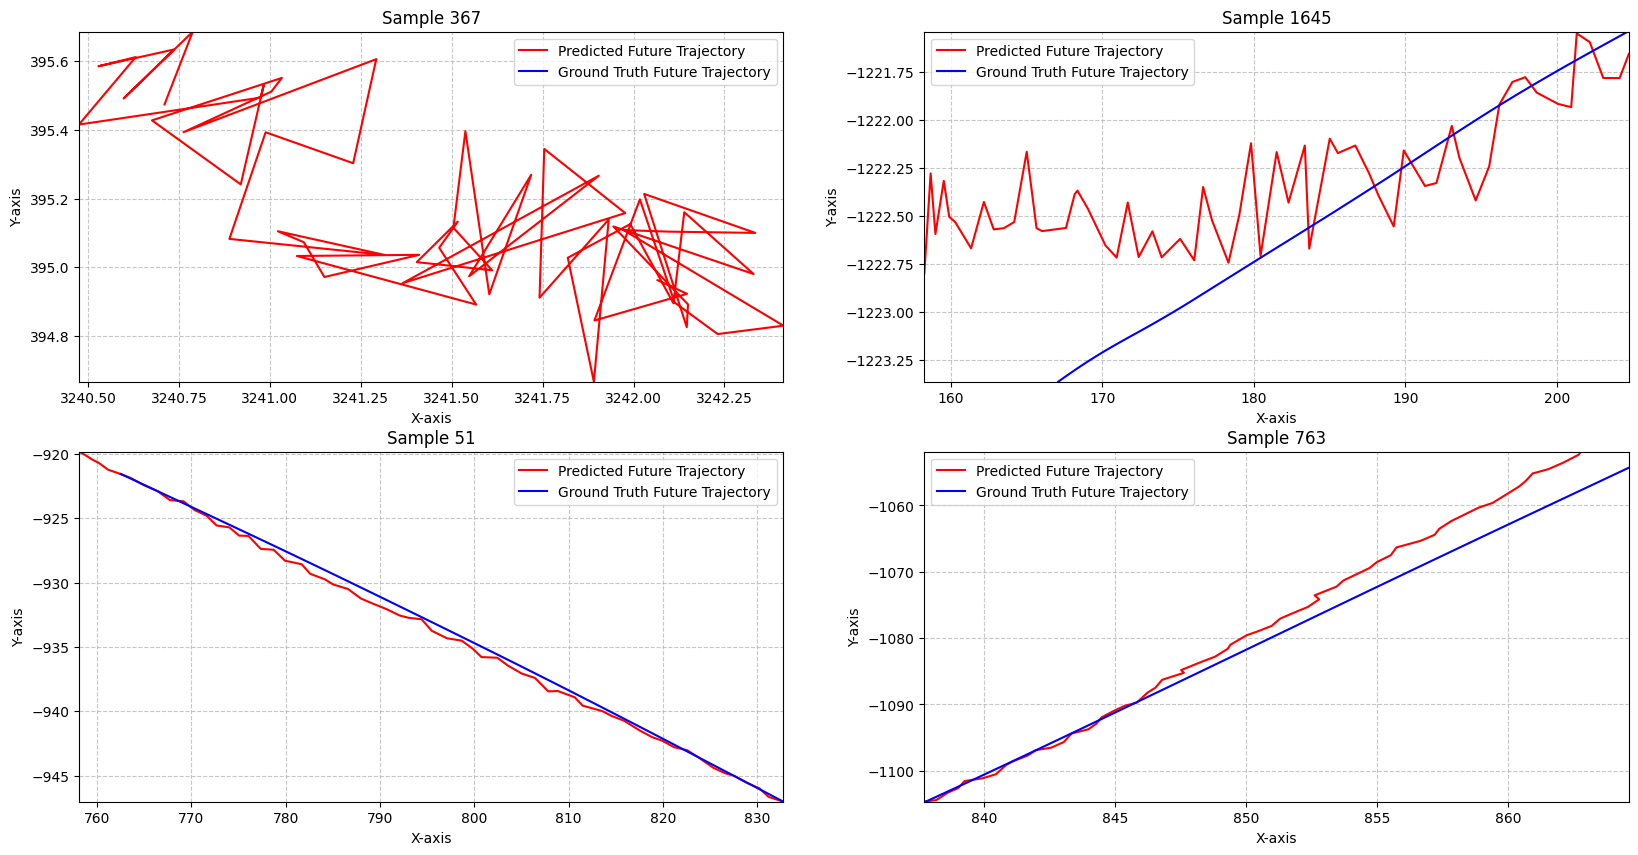

In [ ]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# randomly select 4 samples from the validation set
random_indices = random.sample(range(len(val_dataset)), 4)
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()  # Flatten the array to iterate single axes objects

for i, idx in enumerate(random_indices):
    data = val_dataset[idx]
    batch = Batch.from_data_list([data]).to(device)
    pred = model(batch)
    gt = batch.y.view(batch.num_graphs, 60, 2)

    pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
    gt = gt * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)

    pred = pred.detach().cpu().numpy()
    gt = gt.detach().cpu().numpy()

    plot_trajectory(axes[i], pred, gt, title=f"Sample {idx}")

plt.show()

#### Output your predictions of the best model on the test set

In [ ]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model = torch.load("best_model.pt")
# model = AdvancedTransformerModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
# model = LSTM().to(device)
model = GNNTransformerLite(
    gnn_hidden=256,
    gnn_heads=8,
    gnn_layers=4,
    trans_dim=256,
    trans_heads=8,
    trans_layers=4,
    dropout=0
).to(device)
model.load_state_dict(best_model)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_norm = model(batch)
        
        # Reshape the prediction to (N, 60, 2)
        pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())

pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission.csv', index=True)

## Step 4: Summarize your experiments and results in table and figures in the submitted PDF file for Question 3 Problem A

## Step 5: Analyze the results, identify the issues and plan for the improvement in the submitted PDF file for Question 3 Problem B